# probStuUD vs. Strangeness

In this notebook, we examine the impact of the StuUD parameter on the number of strange hadrons in each event. We use the training data from the original DCTR notebook, and see the distributions of the number of strange hadrons in small intervals of StuUD. Then, we check how the distributions evolve over each interval. Finally, we compare these trends with what the DCTR model has learned by seeing the reweighted distributions over the same interval.

We also plot the discrete distributions for the default and unknown datasets used during fitting.

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Sequential
from keras.layers import Lambda, Dense, Input, Layer, Dropout
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import LambdaCallback, EarlyStopping
import keras.backend as K
import keras

# energyflow imports
import energyflow as ef
from energyflow.utils import remap_pids

import inspect

Using TensorFlow backend.


In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
print(tf.__version__)

1.15.0


# Load Data

## Utilities

In [5]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [6]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    #remap_pids(X, pid_i=3)
    return X

## Process data

In [7]:
# Path to downloaded data from Zenodo
data_dir = '/data0/users/aandreassen/zenodo/'

In [8]:
dataset = np.load(data_dir + '1D_probStoUD_train.npz')

In [9]:
X = dataset['X']
Y = dataset['Y']

In [10]:
X = preprocess_data(X)
Y = to_categorical(Y, num_classes=2)

In [11]:
# strange hadrons particle IDs
strange_PIDs = np.array([130, 310, 311, 321, 3122, 3222, 3212, 3112])

# add anti-particles
strange_PIDs = np.concatenate([strange_PIDs,-strange_PIDs])
X_strangeness = []

In [12]:
# Getting training data strangeness

for event in X:
    probStoUD = event[0][6]
    PIDs = event[:, 3]
    number_strange_hadrons = 0
    for PID in PIDs:
        number_strange_hadrons += PID in strange_PIDs
    X_strangeness.append([number_strange_hadrons, probStoUD])
    
X_strangeness = np.array(X_strangeness)

In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(X_strangeness, Y, test_size=0.2)

# Training a DCTR Model
First, we need to train a DCTR model to provide us with a reweighting function to be used during fitting.
This is taken directly from the first Gaussian Notebook.

## Build Model

In [14]:
inputs = Input((2,))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)

outputs = Dense(2, activation='softmax')(hidden_layer_3)

dctr_model = Model(inputs = inputs, outputs = outputs)
dctr_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics= ['accuracy'])

## Train DCTR model

In [15]:
earlystopping = EarlyStopping(patience = 10,
                              restore_best_weights=True)
dctr_model.fit(X_train, Y_train, 
               epochs=200, batch_size = 10000, 
               validation_data = (X_val, Y_val), 
               verbose = 1, 
               callbacks = [earlystopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 1440000 samples, validate on 360000 samples
Epoch 1/200





1440000/1440000 [==============================] - 3s 2us/step - loss: 0.6923 - acc: 0.5155 - val_loss: 0.6916 - val_acc: 0.5179
Epoch 2/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6912 - acc: 0.5206 - val_loss: 0.6911 - val_acc: 0.5221
Epoch 3/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6904 - acc: 0.5250 - val_loss: 0.6901 - val_acc: 0.5249
Epoch 4/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6899 - acc: 0.5269 - val_loss: 0.6897 - val_acc: 0.5270
Epoch 5/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6897 - acc: 0.5270 - val_loss: 0.6899 - val_acc: 0.5261
Epoch 6/200
1440000/1440000 [==============================] - 2s 2us/step - loss: 0.6897 - acc: 0.5271 - val_loss: 0.6897 - val_acc: 0.5271

# Comparison

## Defining reweighting functions

$w(x_{T,i},\theta)=((f(x_{T,i},\theta)/(1-f(x_{T,i},\theta)))$

Takes observable from simulation ${\bf \theta_0}$ and weights it to observable from data (target) ${\bf \theta_1}$.

In [16]:
def reweight(d): #from NN (DCTR)
    f = dctr_model(d)
    weights = (f[:,1])/(f[:,0])
    weights = K.expand_dims(weights, axis = 1)
    return weights

In [17]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
unknown_dataset = np.load(data_dir + 'test1D_probStoUD.npz')

## Default Distribution

In [18]:
bins = np.arange(0, 15)

X_0_jet = default_dataset['jet']
X_0 = []
for event in X_0_jet:
    PIDs = event[:, 3]
    number_strange_hadrons = 0
    for PID in PIDs:
        number_strange_hadrons += PID in strange_PIDs
    X_0.append([number_strange_hadrons])
X_0 = np.array(X_0)

# The default distribution; StuUD = 0.217
X_0_hist = np.histogram(X_0, bins = bins, density = True)
# Interesting behavior for 0-4 strange hadrons
strangeness_default = X_0_hist[0][:5]

## DCTR Learned Trends

In [19]:
strangeness_reweighted = np.empty((0, 14), float)
strangeness = np.empty((0, 14), float)

In [20]:
interval = 0.0005

StuUD_vals = np.arange(0.1, 0.3, interval)  # uniformly sampled in data

for val in StuUD_vals:

    X_0_inputs = np.concatenate([X_0, val * np.ones_like(X_0)], axis=1)

    weights_1 = K.eval(
        reweight(tf.convert_to_tensor(X_0_inputs, dtype=tf.float32)))

    hist = np.histogram(X_0, bins=bins, density=True,
                        weights=weights_1)  # see the distribution
    strangeness_reweighted = np.append(strangeness_reweighted, np.array([hist[0]]), axis=0)

## Training Data Trends

In [21]:
# only include uniformly sampled data, not default data
Y = dataset['Y']
X = X[Y==1]

In [22]:
for val in StuUD_vals:
    data = []
    # loop over all the events in particular interval
    # X[:,0,6] is value of probStuUD for each event
    for event in X[np.logical_and(val <= X[:, 0, 6], X[:, 0, 6] <
                                  (val + interval))]:
        PIDs = event[:, 3]
        number_strange_hadrons = 0
        for PID in PIDs:
            # count number of strange hadrons in each event
            # i.e. check how many particles in event have strange PIDs
            number_strange_hadrons += PID in strange_PIDs
        data += [number_strange_hadrons]
    hist = np.histogram(data, bins=bins, density=True)  # see the distribution
    strangeness = np.append(strangeness, np.array([hist[0]]), axis=0)

## Unknown Distribution

In [23]:
X_1_jet = default_dataset['jet']
X_1 = []
for event in X_1_jet:
    PIDs = event[:, 3]
    number_strange_hadrons = 0
    for PID in PIDs:
        number_strange_hadrons += PID in strange_PIDs
    X_1.append([number_strange_hadrons])
X_1 = np.array(X_1)

# The unknown distribution; StuUD = 0.275
X_1_hist = np.histogram(X_1, bins = bins, density = True)
# Interesting behavior for 0-4 strange hadrons
strangeness_unknown = X_1_hist[0][:5]

## Comparison Plot

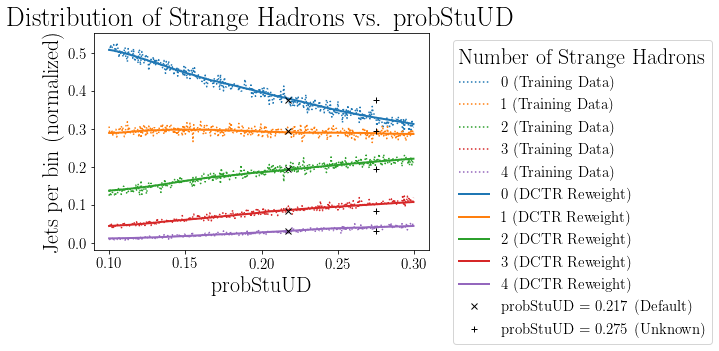

In [24]:
plt.title('Distribution of Strange Hadrons vs. probStuUD')

plt.plot(StuUD_vals,
         strangeness[:, 0],
         label='0 (Training Data)',
         linestyle=':',
         color='C0')
plt.plot(StuUD_vals,
         strangeness[:, 1],
         label='1 (Training Data)',
         linestyle=':',
         color='C1')
plt.plot(StuUD_vals,
         strangeness[:, 2],
         label='2 (Training Data)',
         linestyle=':',
         color='C2')
plt.plot(StuUD_vals,
         strangeness[:, 3],
         label='3 (Training Data)',
         linestyle=':',
         color='C3')
plt.plot(StuUD_vals,
         strangeness[:, 4],
         label='4 (Training Data)',
         linestyle=':',
         color='C4')

plt.plot(StuUD_vals,
         strangeness_reweighted[:, 0],
         label='0 (DCTR Reweight)',
         linewidth=2.,
         color='C0')
plt.plot(StuUD_vals,
         strangeness_reweighted[:, 1],
         label='1 (DCTR Reweight)',
         linewidth=2.,
         color='C1')
plt.plot(StuUD_vals,
         strangeness_reweighted[:, 2],
         label='2 (DCTR Reweight)',
         linewidth=2.,
         color='C2')
plt.plot(StuUD_vals,
         strangeness_reweighted[:, 3],
         label='3 (DCTR Reweight)',
         linewidth=2.,
         color='C3')
plt.plot(StuUD_vals,
         strangeness_reweighted[:, 4],
         label='4 (DCTR Reweight)',
         linewidth=2.,
         color='C4')

plt.plot(np.ones_like(strangeness_default) * 0.217,
         strangeness_default, 'x', color = 'black', label = 'probStuUD = 0.217 (Default)')

plt.plot(np.ones_like(strangeness_unknown) * 0.275,
         strangeness_unknown, '+', color = 'black', label = 'probStuUD = 0.275 (Unknown)')

plt.xlabel('probStuUD')
plt.ylabel('Jets per bin (normalized)')

plt.legend(title='Number of Strange Hadrons', bbox_to_anchor=(1.05, 1.0))
plt.savefig('Reweighted Distribution of Strange Hadrons vs. probStuUD.png',
            bbox_inches='tight')
plt.show()